In [4]:
import tensorflow as tf
import pathlib

data_dir = tf.keras.utils.get_file(origin='https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip',
                                    fname='rockpaperscissors.zip', extract=True)
data_dir = pathlib.Path(data_dir)
data_dir

322879488/322873683 [==============================] - 53s 0us/step


PosixPath('/root/.keras/datasets/rockpaperscissors.zip')

In [5]:
import os

local_dir = os.fspath(data_dir)
local_dir = local_dir.strip('.zip')

In [6]:
file_name = []
cls = []
file_path = []
labels = ['rock', 'paper', 'scissors']

for path, subdir, files in os.walk(local_dir):

  for label in subdir:
    if label not in labels:
      subdir.remove(label)

  for name in files:
    if '.png' in name: 
      file_path.append(os.path.join(path, name)) 
      cls.append(path.split('/')[-1])      
      file_name.append(name)

In [7]:
import pandas as pd

df = pd.DataFrame({"path":file_path,'file_name':file_name,"class":cls})
df.head()

,path,file_name,class
0,/root/.keras/datasets/rockpaperscissors/paper/...,mV9vc1ITH1PrrbF8.png,paper
1,/root/.keras/datasets/rockpaperscissors/paper/...,V7gDBwuUctk8myTw.png,paper
2,/root/.keras/datasets/rockpaperscissors/paper/...,v6Ypsa9vPurMnl20.png,paper
3,/root/.keras/datasets/rockpaperscissors/paper/...,Qbn4RJqessetWPHR.png,paper
4,/root/.keras/datasets/rockpaperscissors/paper/...,aKUFn8PEF7LP8BaX.png,paper


In [8]:
from sklearn.model_selection import train_test_split
X= df['path']
y= df['class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=400)

df_train = pd.DataFrame({'path':X_train, 'class':y_train, 'batch':'train'})
df_val = pd.DataFrame({'path':X_val, 'class':y_val, 'batch':'validation'})

print('train size', len(df_train))
print('val size', len(df_val))

train size 1859
val size 329


In [9]:
df_all = df_train.append([df_val]).reset_index(drop=1)
df_all.sample(10)

,path,class,batch
1321,/root/.keras/datasets/rockpaperscissors/scisso...,scissors,train
446,/root/.keras/datasets/rockpaperscissors/paper/...,paper,train
1617,/root/.keras/datasets/rockpaperscissors/rock/O...,rock,train
983,/root/.keras/datasets/rockpaperscissors/paper/...,paper,train
615,/root/.keras/datasets/rockpaperscissors/paper/...,paper,train
429,/root/.keras/datasets/rockpaperscissors/scisso...,scissors,train
2083,/root/.keras/datasets/rockpaperscissors/rock/l...,rock,validation
367,/root/.keras/datasets/rockpaperscissors/paper/...,paper,train
1588,/root/.keras/datasets/rockpaperscissors/scisso...,scissors,train
238,/root/.keras/datasets/rockpaperscissors/paper/...,paper,train


In [10]:
import shutil
from tqdm.notebook import tqdm as tq

for index, row in tq(df_all.iterrows()):
    dest_path = os.path.join(local_dir,row['batch'],row['class'])
    if os.path.exists(dest_path) == False:
        os.makedirs(dest_path)

    dest_file_name = row['path'].split('/')[-1]
    dest_file_path = os.path.join(dest_path, dest_file_name)
    
    if os.path.exists(dest_file_path) == False:
      shutil.copy2(row['path'],dest_file_path)

In [170]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(local_dir, 'train')
val_dir = os.path.join(local_dir, 'validation')

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,                                  
                    fill_mode = 'nearest')
 
val_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=90,
                  horizontal_flip=True,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,                 
                  fill_mode = 'nearest')

In [181]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(16))
  model.add(Dropout(0.2))

  model.add(Dense(3))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [182]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)

Found 1859 images belonging to 3 classes.
Found 329 images belonging to 3 classes.


In [183]:
model = cnn_model()
model_hist = model.fit_generator(
                train_generator,
                steps_per_epoch=len(train_generator),
                epochs=10,
                validation_data=val_generator,
                validation_steps=len(val_generator),
                shuffle=True)

Epoch 1/10
93/93 [==============================] - 95s 1s/step - loss: 1.1058 - accuracy: 0.3303 - val_loss: 1.1059 - val_accuracy: 0.3313
Epoch 2/10
93/93 [==============================] - 94s 1s/step - loss: 1.0805 - accuracy: 0.3959 - val_loss: 0.9560 - val_accuracy: 0.5410
Epoch 3/10
93/93 [==============================] - 94s 1s/step - loss: 0.9558 - accuracy: 0.5385 - val_loss: 0.8796 - val_accuracy: 0.5623
Epoch 4/10
93/93 [==============================] - 96s 1s/step - loss: 0.8016 - accuracy: 0.6391 - val_loss: 0.8710 - val_accuracy: 0.7264
Epoch 5/10
93/93 [==============================] - 94s 1s/step - loss: 0.5521 - accuracy: 0.7854 - val_loss: 0.3622 - val_accuracy: 0.8967
Epoch 6/10
93/93 [==============================] - 91s 980ms/step - loss: 0.4176 - accuracy: 0.8580 - val_loss: 0.0503 - val_accuracy: 0.9149
Epoch 7/10
93/93 [==============================] - 96s 1s/step - loss: 0.3048 - accuracy: 0.9032 - val_loss: 0.1456 - val_accuracy: 0.8754
Epoch 8/10
93/93 

In [184]:
loss, acc = model.evaluate(
              train_generator,
              steps=len(train_generator),
              verbose=1)
print('Accuracy on train data: {:.4f} \nLoss on train data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(
              val_generator,
              steps=len(val_generator),
              verbose=1)
print('Accuracy on validation data: {:.4f} \nLoss on validation data: {:.4f}'.format(acc,loss),'\n')

93/93 [==============================] - 33s 356ms/step
Accuracy on train data: 0.9473 
Loss on train data: 0.0532 

17/17 [==============================] - 6s 351ms/step
Accuracy on validation data: 0.9453 
Loss on validation data: 0.5614 



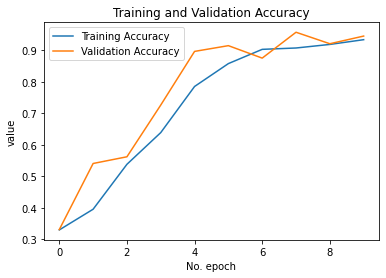

In [185]:
from matplotlib import pyplot as plt

plt.plot(model_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Saving scissortest.png to scissortest.png
Saving rocktest.png to rocktest.png
Saving papertest.png to papertest.png
scissors 0.9871279
rock 0.979079
paper 0.9999963


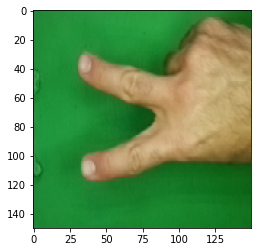

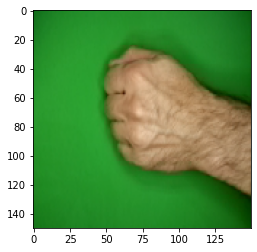

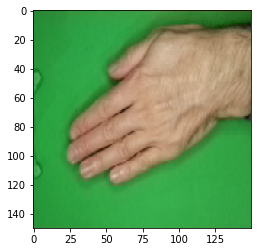

In [199]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

%matplotlib inline

img_upload = files.upload()

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

labels = ['paper', 'rock', 'scissors']

for img_path in img_upload.keys():
 
  # predicting images
  path = img_path
  img = image.load_img(path, target_size=(150,150))
  plt.figure()
  plt.imshow(img)

  x = preprocess(img,(150, 150))
  x = reshape([x])

  y = model.predict(x)
  print( labels[np.argmax(y)], np.max(y) )